In [1]:
# Cell 1: Setup and Imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the 'src' directory to the path so we can import our custom code
sys.path.append(os.path.abspath(os.path.join('..')))

# Import our custom optimization logic from src/portfolio_optimizer.py
from src.portfolio_optimizer import optimize_portfolio, calculate_annualized_metrics

# Configure Plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Setup Complete. Libraries Loaded.")

Setup Complete. Libraries Loaded.


In [2]:
# Cell 2: Load Data
# Load Cleaned Data from Task 1
df = pd.read_csv('../data/processed/cleaned_close_prices.csv', index_col=0, parse_dates=True)

# Calculate Daily Returns (Percentage Change)
# We drop the first row because it becomes NaN (cannot calculate change for day 0)
returns = df.pct_change().dropna()

print("Data Loaded. Shape:", returns.shape)
print("\nFirst 5 rows of Returns:")
print(returns.head())

Data Loaded. Shape: (2774, 3)

First 5 rows of Returns:
                TSLA       BND       SPY
Date                                    
2015-01-05 -0.042041  0.002904 -0.018060
2015-01-06  0.005664  0.002895 -0.009419
2015-01-07 -0.001562  0.000602  0.012461
2015-01-08 -0.001564 -0.001563  0.017745
2015-01-09 -0.018802  0.001685 -0.008013


In [3]:
# Cell 3: Annualized Metrics
# We multiply by 252 because there are ~252 trading days in a year
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

print("Expected Annual Returns:")
print(mean_returns)

print("\nCovariance Matrix (Risk Relationships):")
print(cov_matrix)

Expected Annual Returns:
TSLA    0.474914
BND     0.020434
SPY     0.142850
dtype: float64

Covariance Matrix (Risk Relationships):
          TSLA       BND       SPY
TSLA  0.332840  0.001667  0.050172
BND   0.001667  0.002869  0.001013
SPY   0.050172  0.001013  0.031569


In [4]:
# Cell 4: Monte Carlo Simulation
np.random.seed(42) # Set seed so results are reproducible
num_portfolios = 10000
results = np.zeros((3, num_portfolios)) # Array to store results (Vol, Ret, Sharpe)
weights_record = [] # List to store the specific weights for each portfolio

print(f"Simulating {num_portfolios} random portfolios...")

for i in range(num_portfolios):
    # 1. Generate random weights (that sum to 1.0)
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
    weights_record.append(weights)
    
    # 2. Calculate Portfolio Return and Volatility
    portfolio_return = np.sum(mean_returns * weights)
    # The dot product calculation for variance
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # 3. Store results
    results[0,i] = portfolio_std_dev # Risk (X-axis)
    results[1,i] = portfolio_return  # Return (Y-axis)
    # Sharpe Ratio (assuming 0% risk-free rate for simplicity)
    results[2,i] = results[1,i] / results[0,i]

# Convert to DataFrame for easier analysis
results_frame = pd.DataFrame(results.T, columns=['Volatility', 'Return', 'Sharpe'])
print("Simulation Complete.")

Simulating 10000 random portfolios...
Simulation Complete.


In [5]:
# Cell 5: Optimization Results

# 1. Locate the Max Sharpe Portfolio (Highest value in column 'Sharpe')
max_sharpe_idx = results_frame['Sharpe'].idxmax()
max_sharpe_port = results_frame.iloc[max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

# 2. Locate the Min Volatility Portfolio (Lowest value in column 'Volatility')
min_vol_idx = results_frame['Volatility'].idxmin()
min_vol_port = results_frame.iloc[min_vol_idx]
min_vol_weights = weights_record[min_vol_idx]

print("--- Optimal Portfolio (Max Sharpe Ratio) ---")
print(f"Return:     {max_sharpe_port['Return']:.2%}")
print(f"Volatility: {max_sharpe_port['Volatility']:.2%}")
print(f"Sharpe Ratio: {max_sharpe_port['Sharpe']:.2f}")
print("Weights:")
for i, asset in enumerate(mean_returns.index):
    print(f"  {asset}: {max_sharpe_weights[i]:.2%}")

print("\n--- Safest Portfolio (Min Volatility) ---")
print(f"Return:     {min_vol_port['Return']:.2%}")
print(f"Volatility: {min_vol_port['Volatility']:.2%}")
print("Weights:")
for i, asset in enumerate(mean_returns.index):
    print(f"  {asset}: {min_vol_weights[i]:.2%}")

--- Optimal Portfolio (Max Sharpe Ratio) ---
Return:     10.40%
Volatility: 10.52%
Sharpe Ratio: 0.99
Weights:
  TSLA: 10.33%
  BND: 59.78%
  SPY: 29.89%

--- Safest Portfolio (Min Volatility) ---
Return:     3.07%
Volatility: 5.28%
Weights:
  TSLA: 0.01%
  BND: 91.66%
  SPY: 8.33%


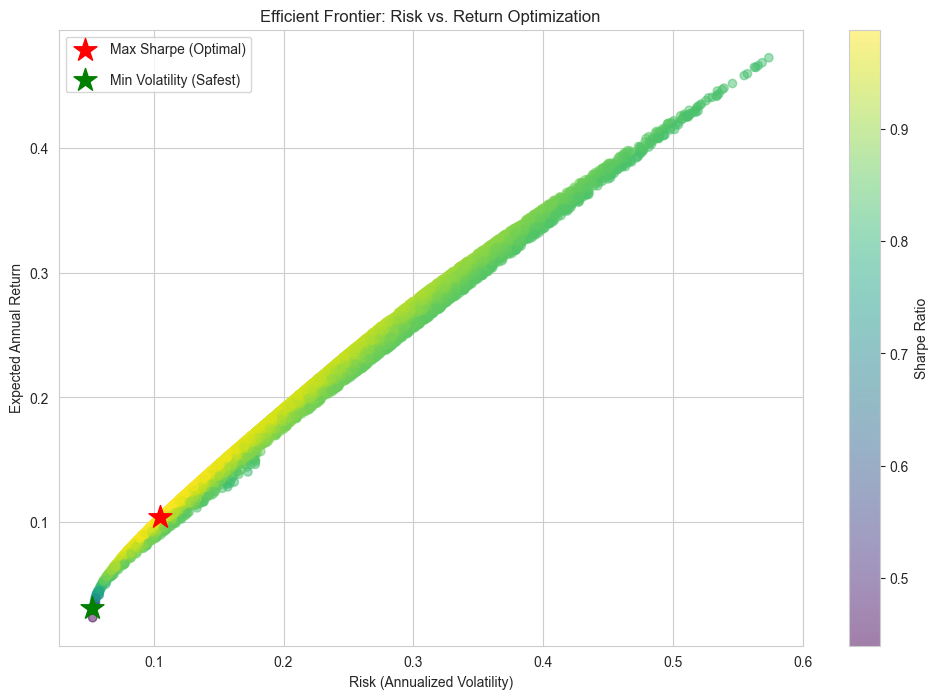

In [6]:
# Cell 6: Visualization
plt.figure(figsize=(12, 8))

# Scatter plot of all portfolios
# Color (c) is determined by Sharpe Ratio
plt.scatter(results_frame.Volatility, results_frame.Return, c=results_frame.Sharpe, cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

# Highlight the Optimal Portfolio (Red Star)
plt.scatter(max_sharpe_port['Volatility'], max_sharpe_port['Return'], marker='*', color='red', s=300, label='Max Sharpe (Optimal)')

# Highlight the Safest Portfolio (Green Star)
plt.scatter(min_vol_port['Volatility'], min_vol_port['Return'], marker='*', color='green', s=300, label='Min Volatility (Safest)')

plt.title('Efficient Frontier: Risk vs. Return Optimization')
plt.xlabel('Risk (Annualized Volatility)')
plt.ylabel('Expected Annual Return')
plt.legend(labelspacing=1.2)
plt.show()